<a href="https://colab.research.google.com/github/vimesh630/Revenue_Forecasting/blob/main/XGBoost_for_Revenue_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import Required Libraries & Mount Google Drive

In [60]:
!pip install optuna

import pandas as pd
import xgboost as xgb
import numpy as np
import os
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Define Paths

In [61]:
output_dir = "/content/drive/MyDrive/VERGER/Revenue_Forecasting"
train_path = os.path.join(output_dir, "train_feature_engineered_forecast_data.csv")
test_path = os.path.join(output_dir, "test_feature_engineered_forecast_data.csv")

#3. Load Data

In [62]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

#4. Handle Infinite Values and NaNs

In [63]:
train_df = train_df.replace([np.inf, -np.inf], np.nan).fillna(0)
test_df = test_df.replace([np.inf, -np.inf], np.nan).fillna(0)

#5. Prepare Features and Targets

In [64]:
target_col = "Forecast_Revenue"
drop_cols = ["Year", "Month", "Account", "Product", "Type", "Quarter", "date"]

X_train = train_df.drop(columns=drop_cols + [target_col], errors="ignore")
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols + [target_col], errors="ignore")
y_test = test_df[target_col]

#6. Apply Log Transformation to Target

In [65]:
y_train_log = np.log1p(y_train)  # log(1+y)
y_test_log = np.log1p(y_test)

#7. Define Optuna Objective Function

In [66]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "tree_method": "hist"
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train_log, eval_set=[(X_test, y_test_log)],
              verbose=False) # Removed early_stopping_rounds

    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

#8. Run Optuna Study

In [67]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200) # Increase n_trials value to get better results
print("✅ Best params:", study.best_params)
print("✅ Best RMSE:", study.best_value)

[I 2025-08-18 06:35:37,461] A new study created in memory with name: no-name-d74580ed-7e1b-47be-9293-73e5b92e4678
[I 2025-08-18 06:35:38,418] Trial 0 finished with value: 13467.662978337594 and parameters: {'n_estimators': 385, 'learning_rate': 0.1230461190710709, 'max_depth': 4, 'subsample': 0.605802635327959, 'colsample_bytree': 0.7176123927897196, 'gamma': 4.84317521609529, 'reg_alpha': 0.9217304070452859, 'reg_lambda': 0.8585787312917492}. Best is trial 0 with value: 13467.662978337594.
[I 2025-08-18 06:35:47,027] Trial 1 finished with value: 13023.324033133336 and parameters: {'n_estimators': 510, 'learning_rate': 0.04770623833472292, 'max_depth': 5, 'subsample': 0.7558239706888049, 'colsample_bytree': 0.8291514215137248, 'gamma': 2.124568317019669, 'reg_alpha': 2.915857181713945, 'reg_lambda': 3.7845832294471404}. Best is trial 1 with value: 13023.324033133336.
[I 2025-08-18 06:36:00,503] Trial 2 finished with value: 12489.639062763465 and parameters: {'n_estimators': 957, 'learn

✅ Best params: {'n_estimators': 456, 'learning_rate': 0.08266058562706274, 'max_depth': 4, 'subsample': 0.8246448639059696, 'colsample_bytree': 0.7723521888437348, 'gamma': 0.009650438225014664, 'reg_alpha': 0.10991174906329396, 'reg_lambda': 1.563419287328694}
✅ Best RMSE: 4492.326815807107


#9. Train the Model with Best Parameters

In [77]:
best_params = study.best_params
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7723521888437348, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.009650438225014664, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08266058562706274,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=456, n_jobs=None,
             num_parallel_tree=None, ...)

#10. Predictions

In [78]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

#11. Model Evaluation

In [79]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n📊 Final Model Performance (After Tuning):")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


📊 Final Model Performance (After Tuning):
RMSE: 6,339.22
MAE: 1,447.05
MAPE: 11.44%
R²: 0.9545


#12. Segmented Performance

In [80]:
test_results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
test_results["Error"] = test_results["Actual"] - test_results["Predicted"]
test_results["APE"] = np.abs(test_results["Error"] / test_results["Actual"]) * 100

segments = {
    "<5K": test_results[test_results["Actual"] < 5000],
    "5K-10K": test_results[(test_results["Actual"] >= 5000) & (test_results["Actual"] < 10000)],
    ">10K": test_results[test_results["Actual"] >= 10000],
}

print("\n📊 Segmented Performance (Tuned):")
for seg, data in segments.items():
    if len(data) > 0:
        seg_mae = data["Error"].abs().mean()
        seg_mape = data["APE"].mean()
        print(f"{seg}: MAE={seg_mae:,.2f}, MAPE={seg_mape:.2f}% (n={len(data)})")
    else:
        print(f"{seg}: No data points")


📊 Segmented Performance (Tuned):
<5K: MAE=208.93, MAPE=16.96% (n=121)
5K-10K: MAE=486.35, MAPE=6.13% (n=48)
>10K: MAE=3,576.69, MAPE=6.94% (n=92)


#13. Optuna Visualization

In [ ]:
import optuna.visualization as vis

# Optimization history (RMSE over trials)
fig1 = vis.plot_optimization_history(study)
fig1.show()

# Hyperparameter importance
fig2 = vis.plot_param_importances(study)
fig2.show()

# Parallel coordinate plot (hyperparameters vs RMSE)
fig3 = vis.plot_parallel_coordinate(study)
fig3.show()

# Contour plot (interaction between params)
fig4 = vis.plot_contour(study)
fig4.show()

#14. Save the Model

In [73]:
model.save_model(os.path.join(output_dir, "xgboost_revenue_model_log.json"))
print(f"✅ Model saved to: {os.path.join(output_dir, 'xgboost_revenue_model_log.json')}")

✅ Model saved to: /content/drive/MyDrive/VERGER/Revenue_Forecasting/xgboost_revenue_model_log.json


#15. Feature Importance

/tmp/ipython-input-2006740044.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




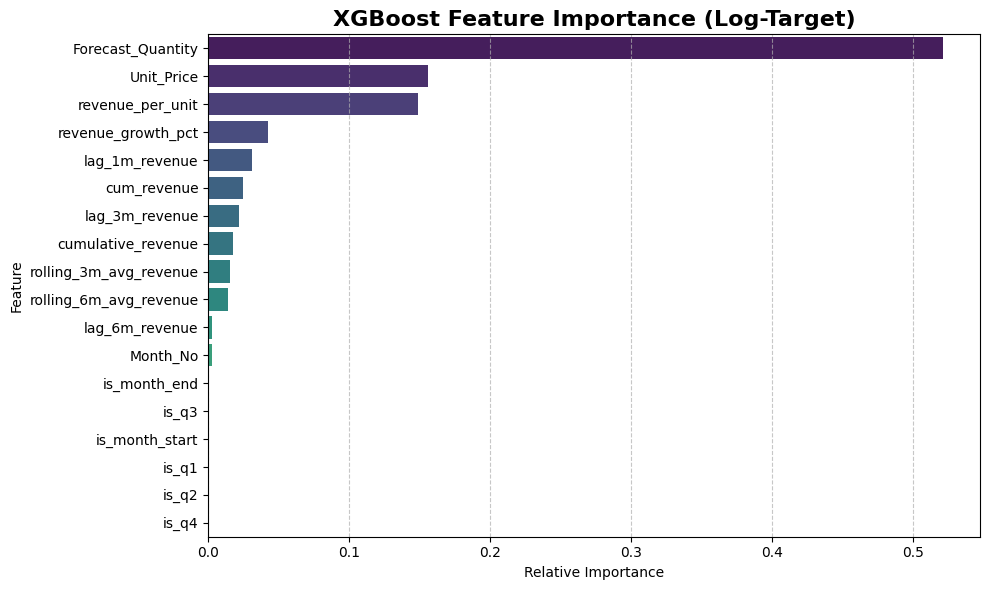

In [74]:
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
    palette='viridis'
)
plt.title('XGBoost Feature Importance (Log-Target)', fontsize=16, weight='bold')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#16. Residual Analysis

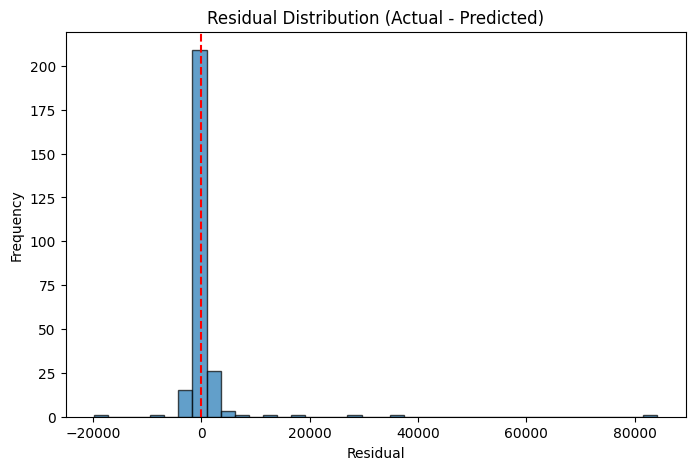

In [75]:
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

#17. Actual Vs Predicted Plot

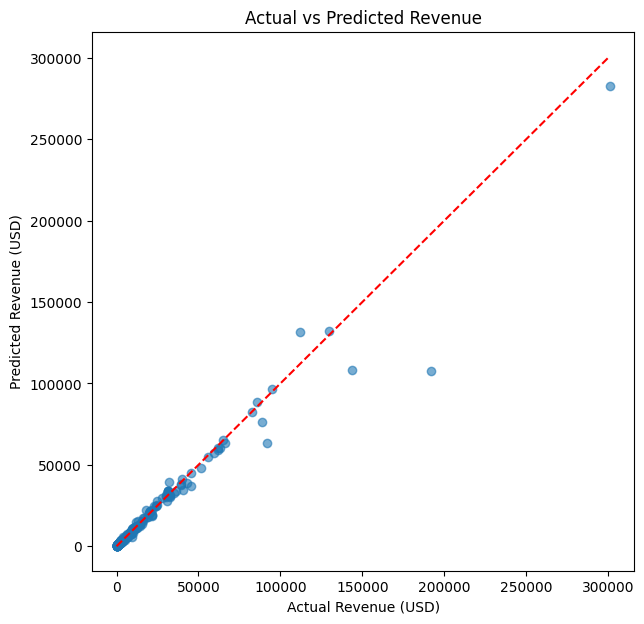

In [76]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Revenue (USD)")
plt.ylabel("Predicted Revenue (USD)")
plt.title("Actual vs Predicted Revenue")
plt.show()